# Shipping Price Prediction using Linear Regression

This notebook builds a linear regression model to predict shipping prices based on shipment features.

In [107]:


# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [108]:
#  LOAD AND CLEAN DATA
df = pd.read_csv('dataset.csv')

df['price ($)'] = df['price ($)'].fillna(df['price ($)'].mean())
df['weight (kg)'] = df['weight (kg)'].fillna(df['weight (kg)'].mean())
df['length (m)'] = df['length (m)'].fillna(df['length (m)'].mean())
df['width (m)'] = df['width (m)'].fillna(df['width (m)'].mean())
df['shipment date'] = pd.to_datetime(df['shipment date'], errors='coerce')
df['shipment date'] = df['shipment date'].fillna(df['shipment date'].mode()[0])


In [109]:
#  FEATURE ENGINEERING
df['log_weight'] = np.log1p(df['weight (kg)'])
df['log_volume'] = np.log1p(df['length (m)'] * df['width (m)'] * df['height (m)'])
df['volume (m^3)'] = df['length (m)'] * df['width (m)'] * df['height (m)']
df['shipment_month'] = df['shipment date'].dt.month
df['shipment_weekday'] = df['shipment date'].dt.weekday
df['is_weekend'] = df['shipment_weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['density'] = df['weight (kg)'] / (df['volume (m^3)'] + 1e-6)
df['log_price'] = np.log1p(df['price ($)'])
df['destination_encoded'] = LabelEncoder().fit_transform(df['destination port'].fillna("unknown"))
df['price_label'] = df['price ($)'].apply(lambda x: "expensive" if x >= 100 else "not expensive")


In [110]:

# PREPARE DATA
features = ['volume (m^3)', 'shipment_month', 'shipment_weekday',
            'log_weight','density' , 'destination_encoded']
X = df[features]
y_reg = df['log_price']
y_cls = df['price_label']

X_imputed = SimpleImputer(strategy="mean").fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imputed)

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_cls, y_test_cls = train_test_split(X_scaled, y_cls, test_size=0.2, random_state=42)


In [111]:


# RANDOM FOREST REGRESSOR
rf_reg_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2]
}
rf_reg_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_reg_params, cv=3, scoring='r2', n_jobs=-1
)
rf_reg_grid.fit(X_train, y_train_reg)

#  XGBOOST REGRESSOR
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}
xgb_grid = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_params, cv=3, scoring='r2', n_jobs=-1
)
xgb_grid.fit(X_train, y_train_reg)

# RANDOM FOREST CLASSIFIER
rf_cls_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2]
}
rf_cls_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_cls_params, cv=3, scoring='accuracy', n_jobs=-1
)
rf_cls_grid.fit(X_train, y_train_cls)

# OUTPUT BEST PARAMETERS
print(" Best Parameters:")
print("Random Forest Regressor:", rf_reg_grid.best_params_)
print("XGBoost Regressor:", xgb_grid.best_params_)
print("Random Forest Classifier:", rf_cls_grid.best_params_)


 Best Parameters:
Random Forest Regressor: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
XGBoost Regressor: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
Random Forest Classifier: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}


 RMSE: 1.1421
 R² Score: 0.5751


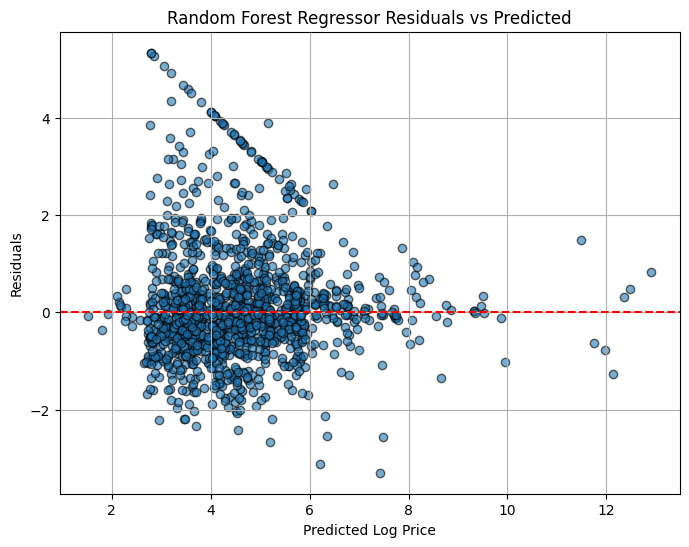

<ipython-input-112-60946599ae7a>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


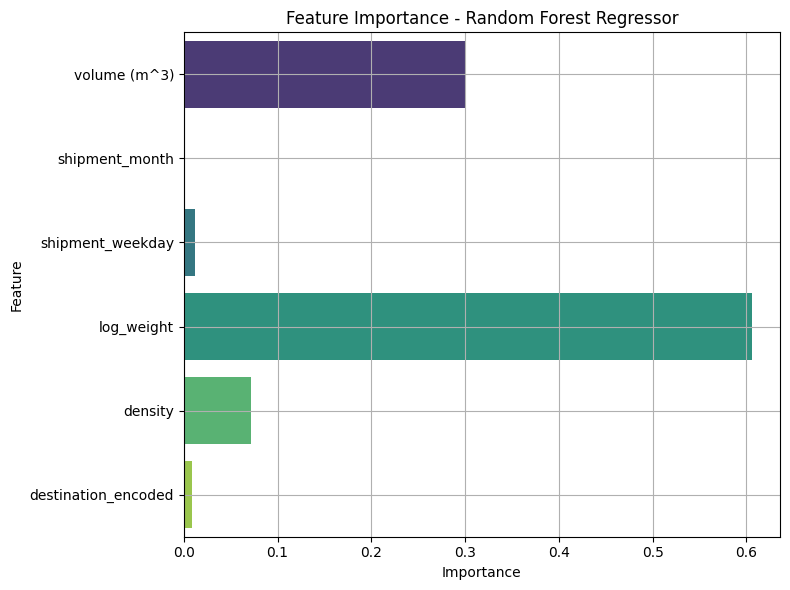

In [112]:
rf_final = RandomForestRegressor(max_depth= 10, min_samples_split= 2, n_estimators= 150)
rf_final.fit(X_train, y_train_reg)
y_pred_rf = rf_final.predict(X_test)

print(f" RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)):.4f}")
print(f" R² Score: {r2_score(y_test_reg, y_pred_rf):.4f}")



residuals_rf = y_test_reg - y_pred_rf
plt.figure(figsize=(8,6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Random Forest Regressor Residuals vs Predicted")
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Feature Importance from Random Forest
importances = rf_final.feature_importances_
feature_names = features

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importance - Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


 RMSE: 1.1410
 R² Score: 0.5759


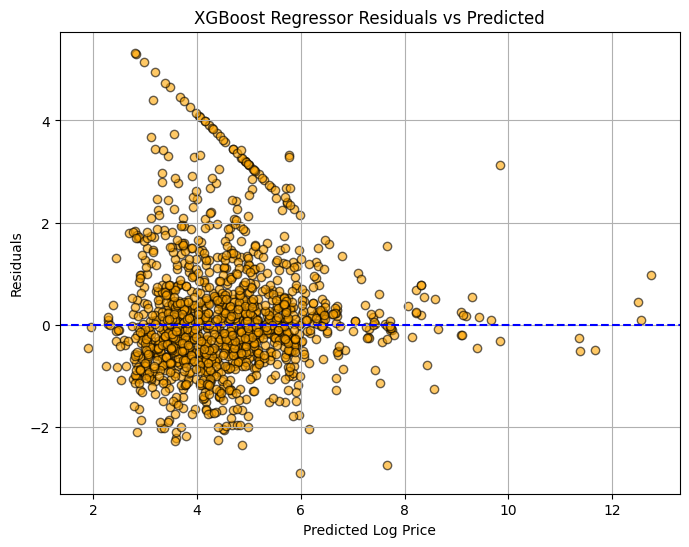

<ipython-input-113-b2ec7f49f9a4>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importance, y=feature_names, palette="magma")


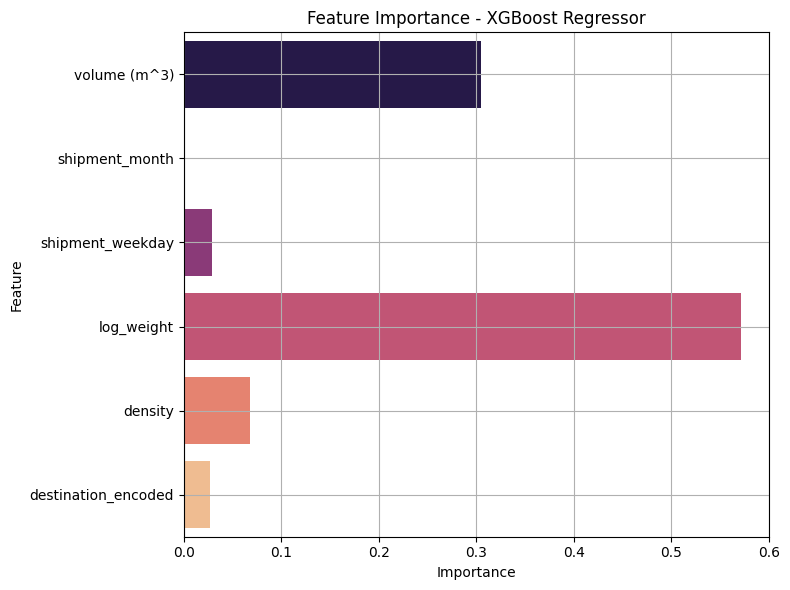

In [113]:
#  XGBOOST REGRESSOR (Hyper-Tuned)


xgb_final = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.05,
                         objective='reg:squarederror', random_state=42)
xgb_final.fit(X_train, y_train_reg)
y_pred_xgb = xgb_final.predict(X_test)

print(f" RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb)):.4f}")
print(f" R² Score: {r2_score(y_test_reg, y_pred_xgb):.4f}")

# Residual plot for XGBoost Regressor
residuals_xgb = y_test_reg - y_pred_xgb
plt.figure(figsize=(8,6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.6, color='orange', edgecolor='k')
plt.axhline(0, color='blue', linestyle='--')
plt.title("XGBoost Regressor Residuals vs Predicted")
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

#feature importance
xgb_importance = xgb_final.feature_importances_

plt.figure(figsize=(8,6))
sns.barplot(x=xgb_importance, y=feature_names, palette="magma")
plt.title("Feature Importance - XGBoost Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()




In [114]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest (Tuned)', 'XGBoost (Tuned)'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))
    ],
    'R² Score': [
        r2_score(y_test_reg, y_pred_rf),
        r2_score(y_test_reg, y_pred_xgb)
    ]
}).round(4)

print(" Final Regression Model Comparison:")
print(comparison_df)


 Final Regression Model Comparison:
                   Model    RMSE  R² Score
0  Random Forest (Tuned)  1.1421    0.5751
1        XGBoost (Tuned)  1.1410    0.5759


Classification Model Performance:
Number of classes: 2
Accuracy: 0.8092857142857143


,precision,recall,f1-score,support
expensive,0.861063,0.729651,0.789929,688.000000
not expensive,0.772338,0.886236,0.825376,712.000000
accuracy,0.809286,0.809286,0.809286,0.809286
macro avg,0.816701,0.807944,0.807653,1400.000000
weighted avg,0.815940,0.809286,0.807956,1400.000000


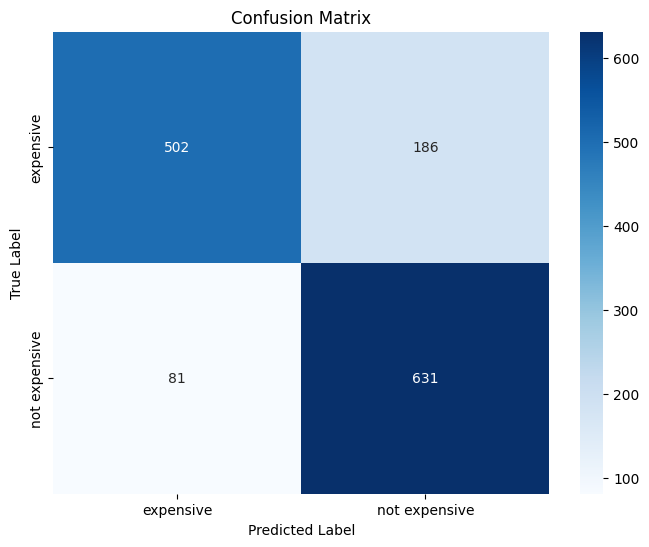

<ipython-input-120-b4ffbb87a4e7>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


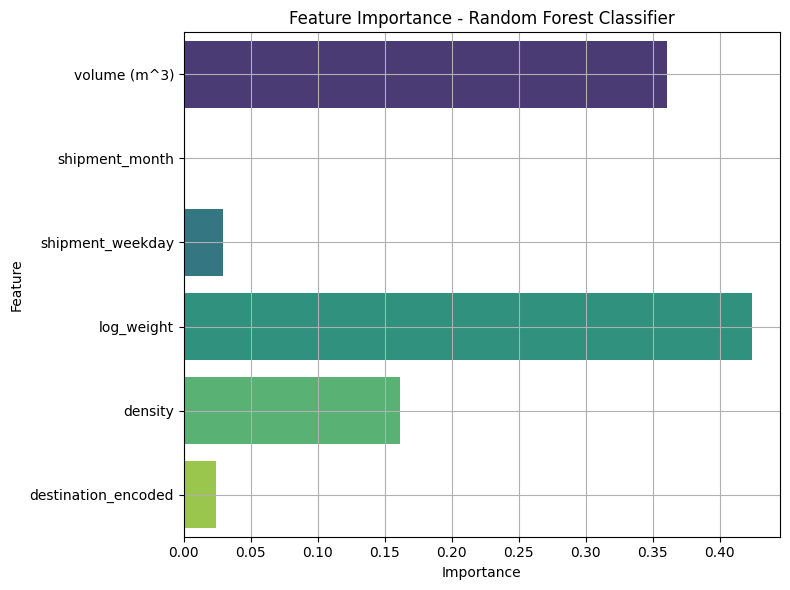

In [120]:
#Classification Model

# Train the Random Forest Classifier
cls_model = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=100,random_state=42)
cls_model.fit(X_train, y_train_cls)

# Predict on test set
y_pred_cls = cls_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_cls, y_pred_cls)
report = classification_report(y_test_cls, y_pred_cls, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print('Classification Model Performance:')
print(f'Number of classes: {len(cls_model.classes_)}')
print('Accuracy:', accuracy)
display(report_df)

# Confusion matrix
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=cls_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cls_model.classes_,
            yticklabels=cls_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

importances = rf_cls_grid.best_estimator_.feature_importances_
feature_names = features

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importance - Random Forest Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()










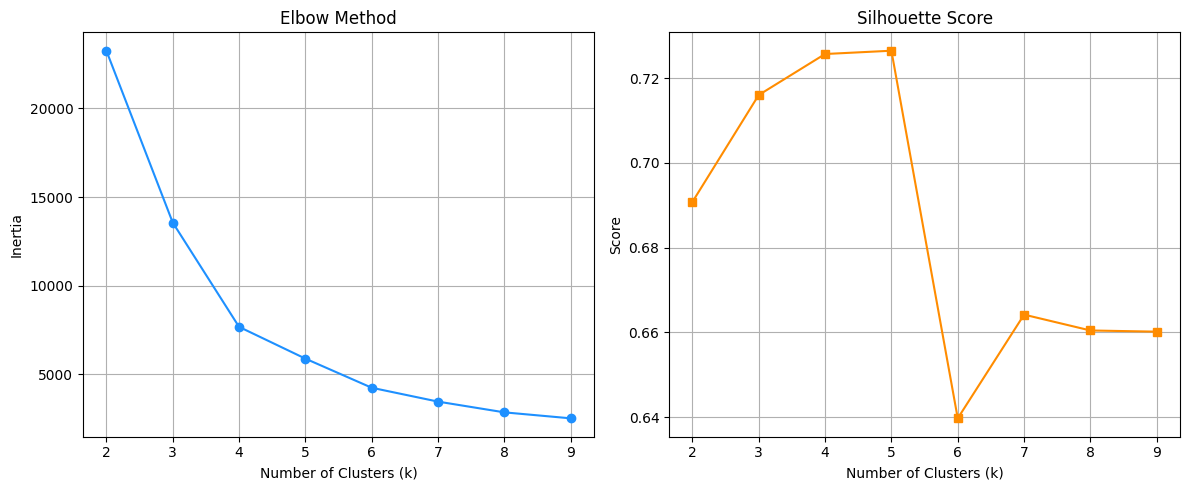

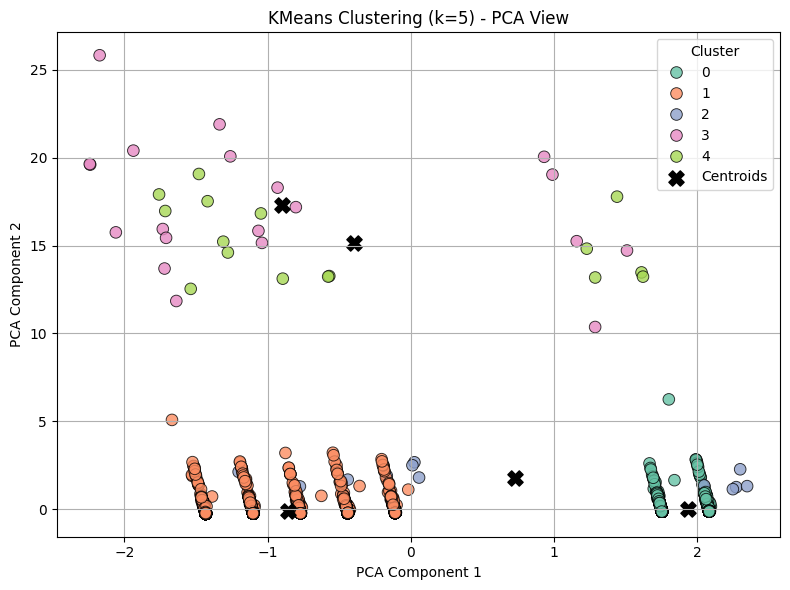

In [116]:
#Clustering (Shipment)

# Step 1: Select and scale features for clustering
features_for_clustering = ['volume (m^3)', 'weight (kg)', 'density',
                           'shipment_month', 'shipment_weekday', 'is_weekend']
X_cluster = df[features_for_clustering]

X_cluster_imputed = SimpleImputer(strategy="mean").fit_transform(X_cluster)
X_cluster_scaled = StandardScaler().fit_transform(X_cluster_imputed)

# Step 2: Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

# Step 3: Try multiple k for Elbow & Silhouette methods
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, labels))

# Step 4: Plot Elbow and Silhouette Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', color='dodgerblue')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='s', color='darkorange')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 5: Fit KMeans with best k
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Step 6: Visualize clusters in 2D PCA space
plt.figure(figsize=(8,6))
palette = sns.color_palette("Set2", best_k)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette=palette, s=70, edgecolor='k', alpha=0.8)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', s=120, marker='X', label='Centroids')
plt.title(f"KMeans Clustering (k={best_k}) - PCA View")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

